In [130]:
import jax.numpy as jnp
from jax import jit, lax
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env, spaces

# Define parameters
gamma = 8
dx = 0.005
dt = 1e-5
control_dt = 0.01  # Control sampling timestep
x = jnp.arange(0, 1 + dx, dx)
nx = len(x)
num_timesteps = int(1 / dt)  # Total simulation time of 1 second
num_control_steps = int(control_dt / dt)  # Number of PDE steps per control action

# Define the source term as a function (vectorized)
@jit
def source_term(x, u):
    return 50 * jnp.cos(gamma * jnp.arccos(x)) * u

# Define the function to perform a single time-integration step (vectorized)
@jit
def integrate_step(state, boundary_control):
    # Compute the diffusion term for all internal points at once
    diffusion_term = (state[2:] - 2 * state[1:-1] + state[:-2]) / dx**2

    # Compute the source term for all internal points at once
    internal_source_term = source_term(x[1:-1], state[1:-1])

    # Update all internal points at once
    new_state = state.at[1:-1].set(state[1:-1] + dt * (diffusion_term + internal_source_term))

    # Apply boundary conditions
    new_state = new_state.at[0].set(0)                # u(x=0) = 0
    new_state = new_state.at[-1].set(boundary_control)  # u(x=1) = control

    return new_state

# Define the JIT-compiled time-integration loop using jax.lax.fori_loop
@jit
def time_integration(state, boundary_control, control_steps):
    # Inner function to call integrate_step repeatedly
    def body_fun(i, state):
        return integrate_step(state, boundary_control)
    
    # Use jax.lax.fori_loop for looping control_steps times
    state = lax.fori_loop(0, control_steps, body_fun, state)
    return state

# Define the environment for the diffusion equation with boundary control
class DiffusionEnv(Env):
    def __init__(self):
        super(DiffusionEnv, self).__init__()
        
        # Define action and observation spaces
        self.action_space = spaces.Box(low=-20, high=20, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(nx,), dtype=np.float32)
        
        # Initialize state
        self.state = jnp.ones(nx, dtype=jnp.float32)  # Initial condition
        self.state = self.state.at[0].set(0)  # Boundary condition at x=0
        self.cumulative_control_l1 = 0  # Reset cumulative control L1 norm at episode start
        self.current_step = 0  # Track the number of time steps

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        
        self.state = jnp.ones(nx, dtype=jnp.float32)
        self.state = self.state.at[0].set(0)  # Enforce boundary condition at x=0
        self.current_step = 0
        return np.array(self.state), {}  # Convert to numpy for compatibility with stable-baselines

    def step(self, action):
        # Apply boundary control at x=1
        boundary_control = action[0]

        # Save the initial state for reward calculation
        initial_state = np.array(self.state)

        # Run the JIT-compiled time-integration loop
        self.state = time_integration(self.state, boundary_control, num_control_steps)

        # Convert state to numpy for compatibility
        new_state = np.array(self.state)

        # Calculate reward: Negative squared norm of state difference
        reward = np.linalg.norm(initial_state) - np.linalg.norm(new_state)

        # Accumulate the L1 norm of control
        self.cumulative_control_l1 += np.abs(boundary_control)

        # If this is the last timestep, adjust the reward based on the final L2 norm
        if self.current_step >= num_timesteps // num_control_steps:
            final_norm = np.linalg.norm(new_state)
            if final_norm <= 20:
                reward = 300 - (1/1000)*self.cumulative_control_l1 - final_norm
            else:
                reward = 0  # No additional reward if L2 norm is not small enough

        # The episode only ends after the full duration (1 second)
        done = self.current_step >= num_timesteps // num_control_steps
        truncated = False  # No truncation

        # Increment the timestep counter
        self.current_step += 1

        return new_state, reward, done, truncated, {}

    def render(self, mode='human'):
        plt.plot(np.array(x), np.array(self.state))
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.title("Solution at the current timestep")
        plt.show()

Plotting...


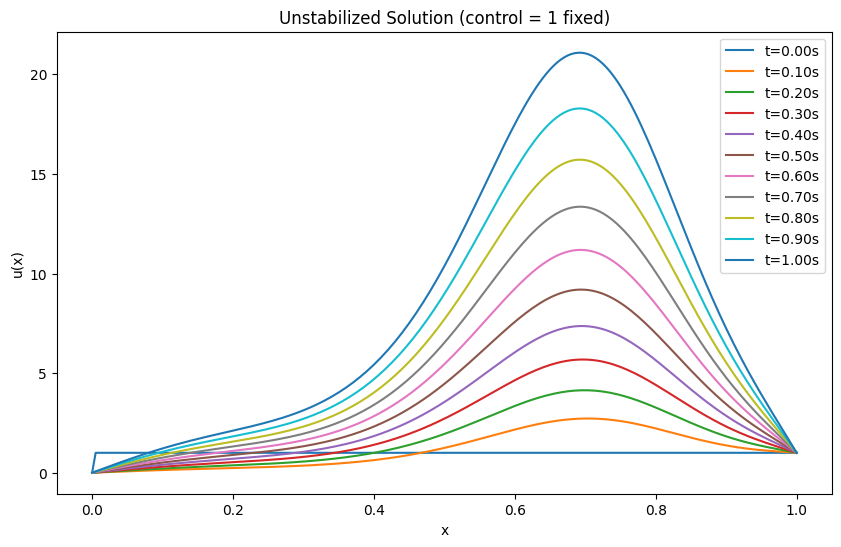

In [ ]:
# Instantiate and test the environment
env = DiffusionEnv()

# Run a simulation with fixed control = 1 for all timesteps (unstabilized solution)
obs, _ = env.reset()  # Unpack observation
fixed_action = np.array([1.0])
states = [obs.copy()]

for _ in range(num_timesteps // num_control_steps):
    obs, reward, done, truncated, _ = env.step(fixed_action)
    states.append(obs.copy())
    if done:
        break

# Plot unstabilized solution
plt.figure(figsize=(10, 6))
for i in range(0, len(states), len(states) // 10):
    plt.plot(x, states[i], label=f"t={i * control_dt:.2f}s")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Unstabilized Solution (control = 1 fixed)")
plt.show()

In [132]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import numpy as np
import os

# Wrap the environment with VecMonitor for reward logging
env = DiffusionEnv()
env = DummyVecEnv([lambda: env])
env = VecMonitor(env)

# Define a separate evaluation environment
eval_env = DiffusionEnv()
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecMonitor(eval_env)

# Set up the directory to save evaluation logs
log_dir = "./ppo_eval_logs/"
os.makedirs(log_dir, exist_ok=True)

# Define the evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=5000,  # Evaluate every 5000 timesteps
    deterministic=True,
    render=False
)

# Train the PPO model with the evaluation callback
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=150000, callback=eval_callback)


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 106      |
| time/              |          |
|    fps             | 2488     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 101          |
|    ep_rew_mean          | 182          |
| time/                   |              |
|    fps                  | 2037         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053204685 |
|    clip_fraction        | 0.0823       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.000472     

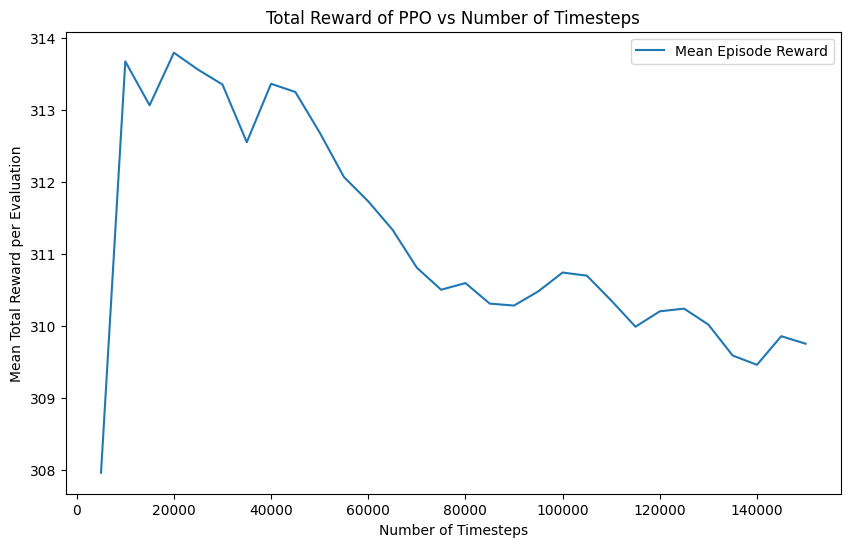

In [ ]:
# Load evaluation results from the logs
# The evaluation logs are stored in a file named "evaluations.npz" in log_path
results = np.load(os.path.join(log_dir, "evaluations.npz"))
timesteps = results["timesteps"]
mean_rewards = results["results"].mean(axis=1)

# Plot total reward vs number of timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mean_rewards, label="Mean Episode Reward")
plt.xlabel("Number of Timesteps")
plt.ylabel("Mean Total Reward per Evaluation")
plt.title("Total Reward of PPO vs Number of Timesteps")
plt.legend()
plt.show()

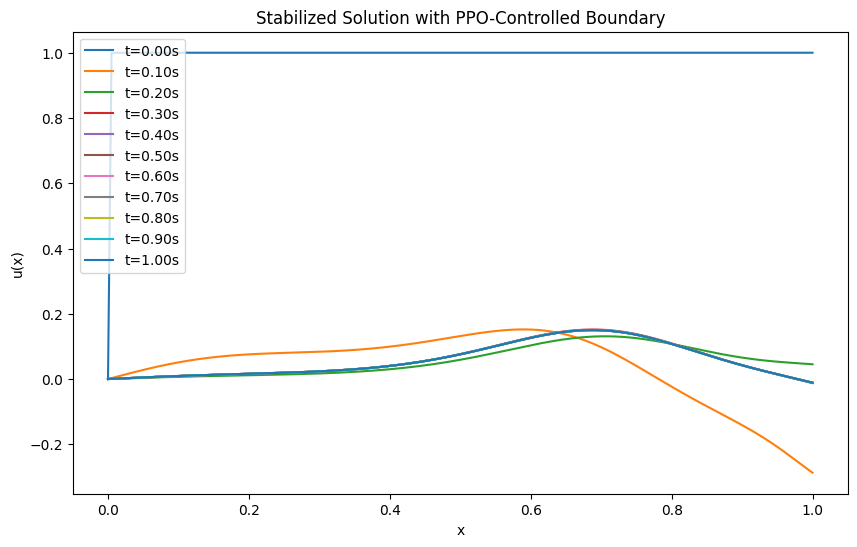

In [134]:
# Test the trained model
obs = env.reset()  # No unpacking needed
states = [obs[0].copy()]  # Extract the initial observation from the wrapped array
for _ in range(num_timesteps // num_control_steps):  # Now `timesteps` and `control_steps` are ensured to be integers
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)  # Now correctly unpacking 4 values
    states.append(obs[0].copy())  # Extract the observation from the wrapped array
    if done:
        break

# Convert states to numpy array for plotting
states = np.array(states).T

# Plot the stabilized solution over time
plt.figure(figsize=(10, 6))
for i in range(0, states.shape[1], states.shape[1] // 10):
    plt.plot(np.array(x), states[:, i], label=f"t={i * control_dt:.2f}s")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Stabilized Solution with PPO-Controlled Boundary")
plt.show()

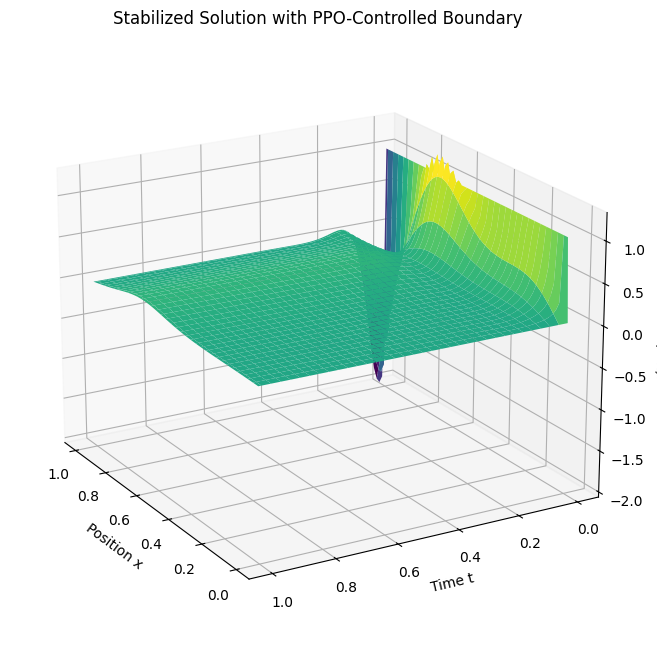

In [135]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Assuming `states` contains the stabilized solution over time with shape (nx, time_steps)
# where `nx` is the spatial dimension and `time_steps` is the temporal dimension.

# Create mesh grid for plotting
X, T = np.meshgrid(np.array(x[::2]), np.arange(states.shape[1]) * control_dt)

# Slice the states array to include only every other x-location
states_reduced = states[::2, :]

# Plot the stabilized solution as a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, states_reduced.T, cmap='viridis')

# Rotate the view to bring t=1 closer to the front
ax.view_init(elev=20, azim=150)  # Adjust azim and elev for a suitable view

# Label the axes
ax.set_xlabel("Position x")
ax.set_ylabel("Time t")
ax.set_zlabel("u(x, t)")
ax.set_title("Stabilized Solution with PPO-Controlled Boundary")

# Show the plot
plt.show()

Output()

Eval num_timesteps=5000, episode_reward=-46.80 +/- 0.00

Eval num_timesteps=10000, episode_reward=-20.49 +/- 0.00

Episode length: 101.00 +/- 0.00

New best mean reward!

Eval num_timesteps=15000, episode_reward=-27.07 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-21.89 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-45.56 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=90.23 +/- 0.23

Episode length: 101.00 +/- 0.00

New best mean reward!

Eval num_timesteps=35000, episode_reward=-21.82 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-94.32 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=45000, episode_reward=-20.06 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=50000, episode_reward=-22.62 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=55000, episode_reward=-1.36 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=-105.84 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=65000, episode_reward=-58.05 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=70000, episode_reward=-143.81 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=75000, episode_reward=-122.31 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=-113.96 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=85000, episode_reward=-79.38 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=90000, episode_reward=-86.79 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=95000, episode_reward=-44.26 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=-50.95 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=105000, episode_reward=-22.77 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=110000, episode_reward=-40.03 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=115000, episode_reward=-14.78 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=-71.95 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=125000, episode_reward=-23.83 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=130000, episode_reward=8.17 +/- 0.45

Episode length: 101.00 +/- 0.00

Eval num_timesteps=135000, episode_reward=-27.36 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=140000, episode_reward=-17.26 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=145000, episode_reward=-32.30 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-10.10 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=155000, episode_reward=-61.24 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=160000, episode_reward=-30.51 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=165000, episode_reward=-47.25 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=-67.60 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=175000, episode_reward=-25.11 +/- 0.63

Episode length: 101.00 +/- 0.00

Eval num_timesteps=180000, episode_reward=5.68 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=185000, episode_reward=-48.03 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=190000, episode_reward=-120.32 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=195000, episode_reward=-14.56 +/- 0.00

Episode length: 101.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=-36.34 +/- 0.63

Episode length: 101.00 +/- 0.00

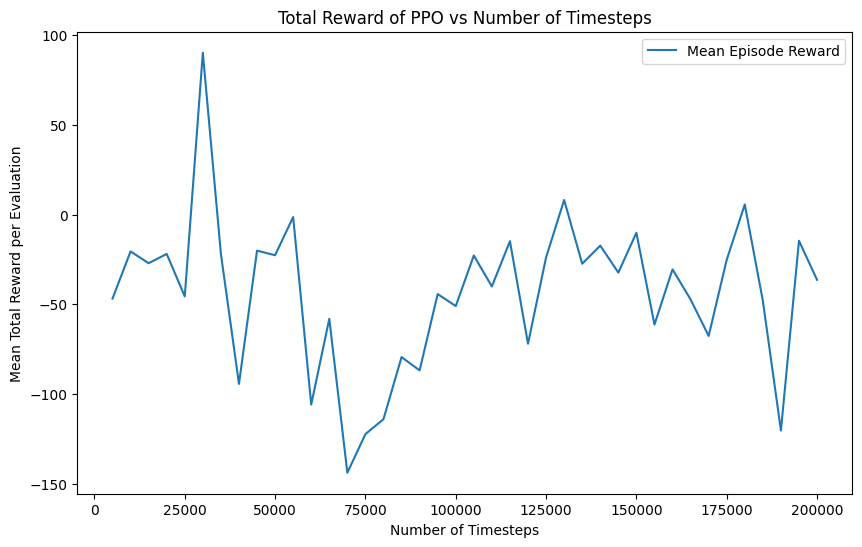

In [97]:
from sbx import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the environment and wrap it with VecMonitor for logging rewards
env = DummyVecEnv([lambda: DiffusionEnv()])
env = VecMonitor(env)

# Define a separate evaluation environment with VecMonitor
eval_env = DummyVecEnv([lambda: DiffusionEnv()])
eval_env = VecMonitor(eval_env)

# Set up the directory to save evaluation logs
log_dir = "./ppo_eval_logs/"
os.makedirs(log_dir, exist_ok=True)

# Set up the evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=5000,  # Evaluate every 5000 timesteps
    deterministic=True,
    render=False
)

# Define the PPO model using sbx
model = PPO("MlpPolicy", env)

# Train the model with the evaluation callback
total_timesteps = 2e5  # Adjust based on convergence needs
model.learn(total_timesteps=total_timesteps, callback=eval_callback, progress_bar=True)

# Load evaluation results from the logs
results = np.load(os.path.join(log_dir, "evaluations.npz"))
timesteps = results["timesteps"]
mean_rewards = results["results"].mean(axis=1)

# Plot total reward vs number of timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mean_rewards, label="Mean Episode Reward")
plt.xlabel("Number of Timesteps")
plt.ylabel("Mean Total Reward per Evaluation")
plt.title("Total Reward of PPO vs Number of Timesteps")
plt.legend()
plt.show()